<a href="https://colab.research.google.com/github/Hossain-Younis/Sign2Text/blob/main/Sign2Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.utils import plot_model, to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.models import load_model

Pre-processing Dataset

In [2]:
# Setting the root directory
root_directory = "/content/drive/MyDrive/Colab Notebooks/Sign2Text/American/"

# Initializing lists to store images and their labels
images = []
labels = []

# Looping through all subdirectories
for subfolder in os.listdir(root_directory):
    subfolder_path = os.path.join(root_directory, subfolder)

    # Checking if it's a directory
    if os.path.isdir(subfolder_path):
        # Looping through files in the subdirectory
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)

            # Checking if the file is a JPEG or JPG image
            if file_name.lower().endswith(('.jpg', '.jpeg')):
                # Loading the image
                image = cv2.imread(file_path, 0)

                # Resizing the image
                image = cv2.resize(image, (32, 32))

                # Converting to a NumPy array and normalizing pixel values
                image = np.array(image, dtype=float) / 255.0

                # Adding the image data to the 'images' list
                images.append(image)

                # Extracting the label from the parent folder
                label = os.path.basename(subfolder)

                # Adding the label to the 'labels' list
                labels.append(label)

# Converting the 'images' list to a NumPy array
images = np.array(images)

# Encoding the labels as integers
label_to_int = {label: i for i, label in enumerate(np.unique(labels))}
labels_encoded = np.array([label_to_int[label] for label in labels], dtype=np.int64)

# Spliting the dataset into train and test sets
X_train, X_test, y_train, y_test= train_test_split(
    images, labels_encoded, test_size=0.3, random_state=42)

# Saving the images and labels as NumPy arrays
save_directory = "/content/drive/MyDrive/Colab Notebooks/Sign2Text/"
np.save(os.path.join(save_directory, 'X_train.npy'), X_train)
np.save(os.path.join(save_directory, 'y_train.npy'), y_train)
np.save(os.path.join(save_directory, 'X_test.npy'), X_test)
np.save(os.path.join(save_directory, 'y_test.npy'), y_test)

Visualizing the Dataset

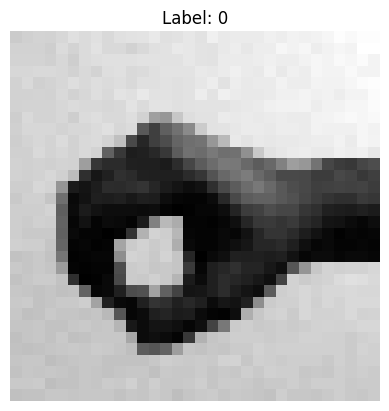

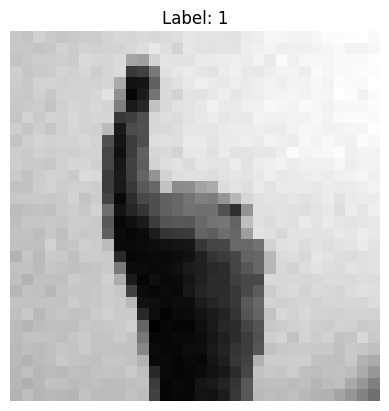

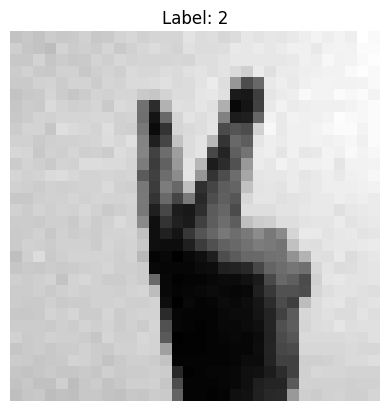

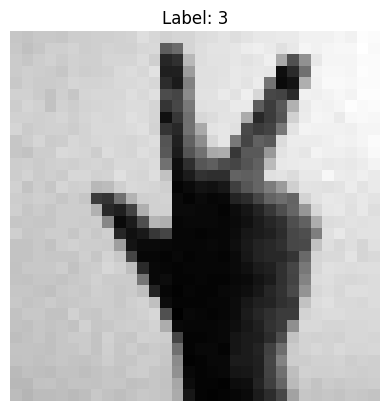

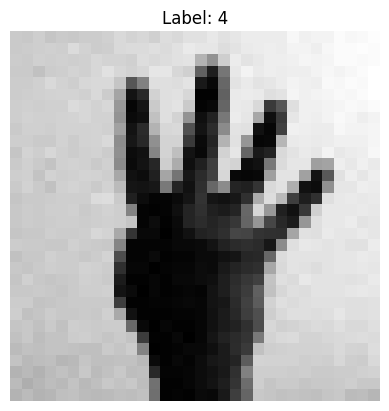

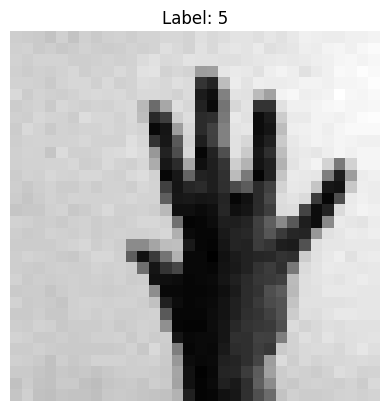

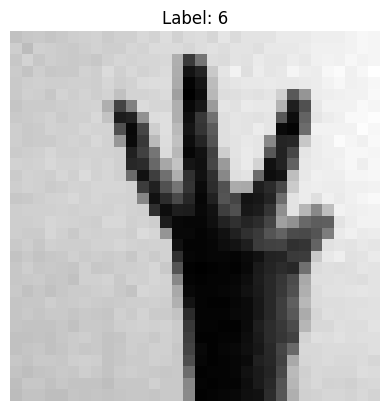

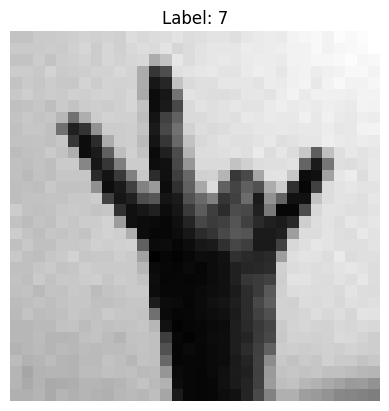

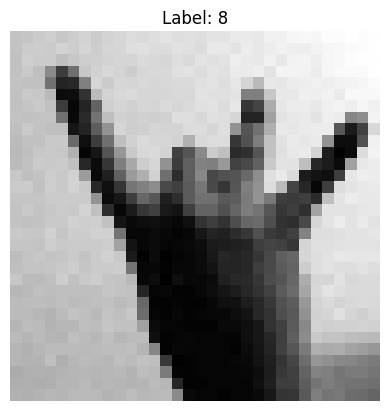

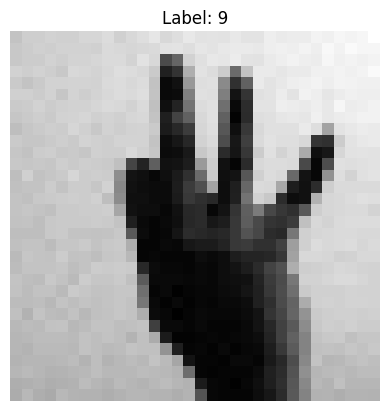

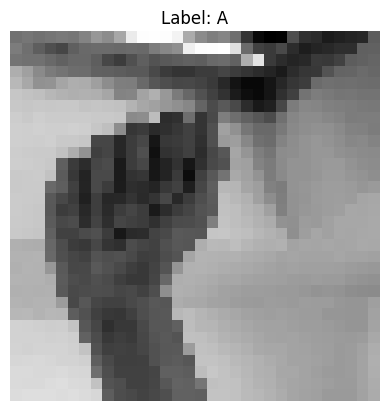

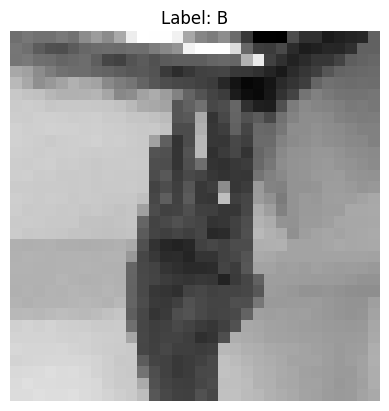

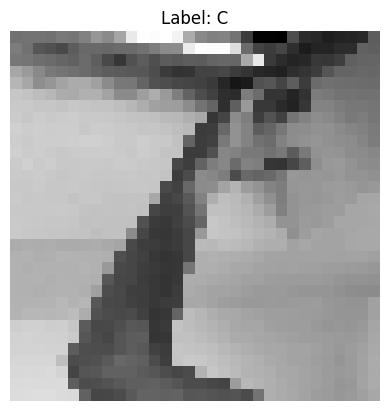

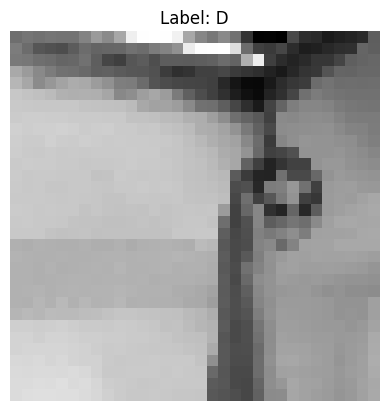

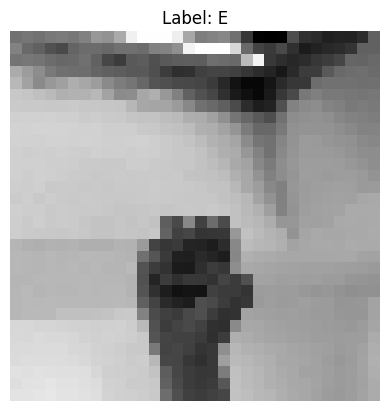

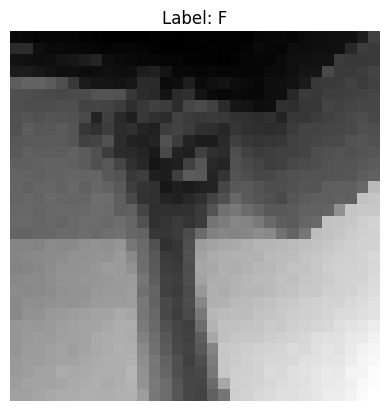

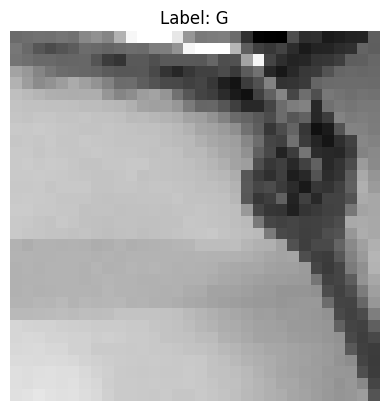

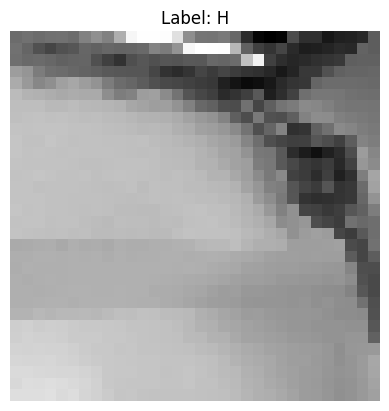

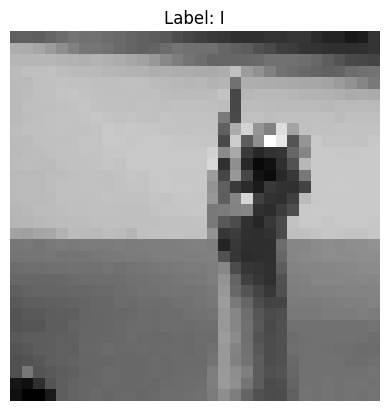

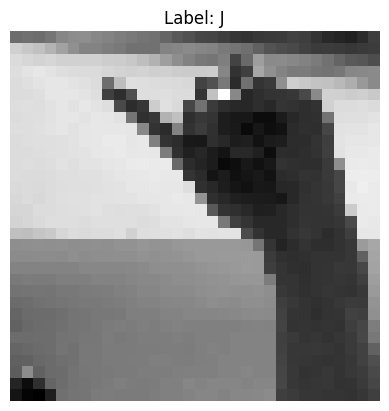

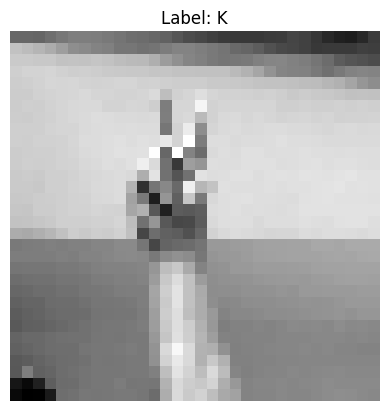

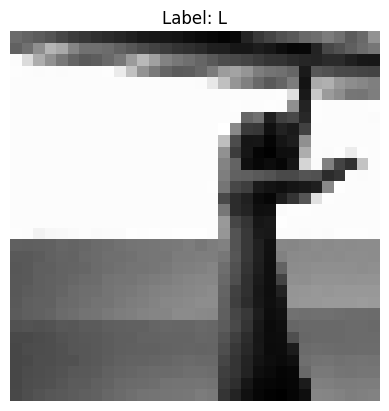

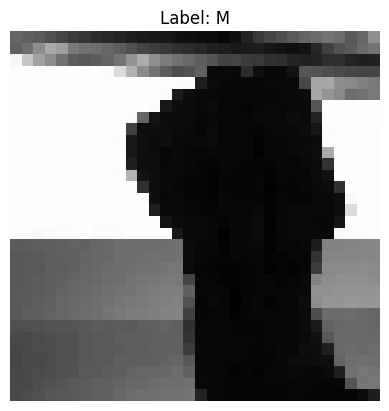

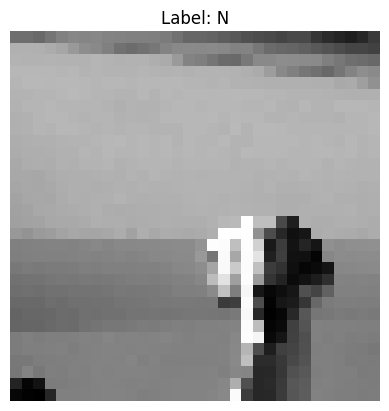

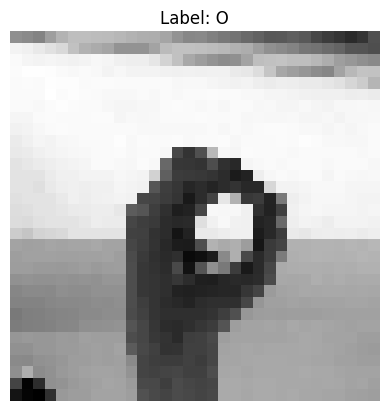

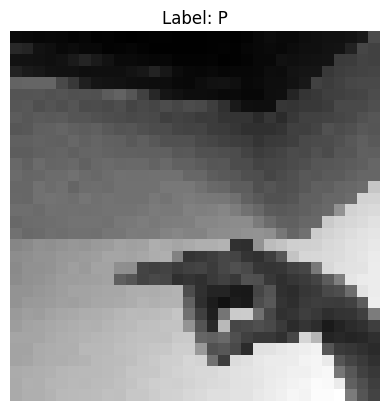

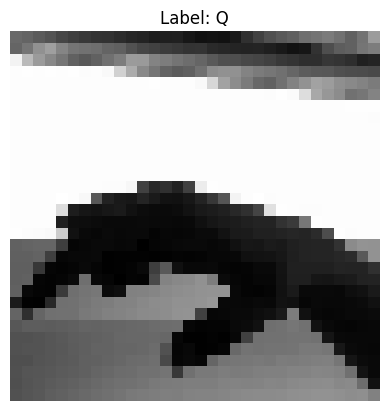

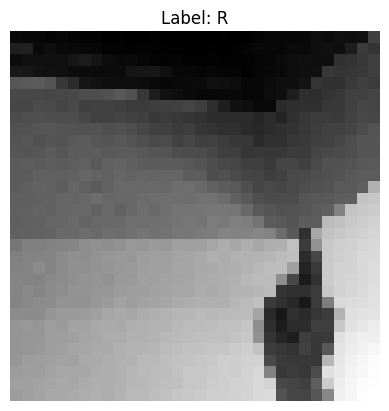

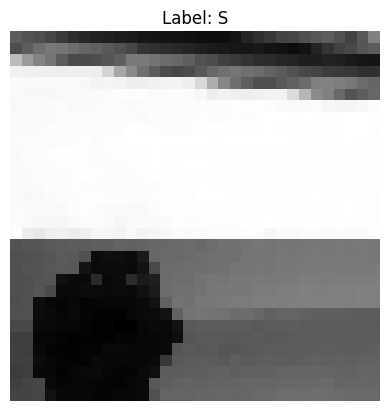

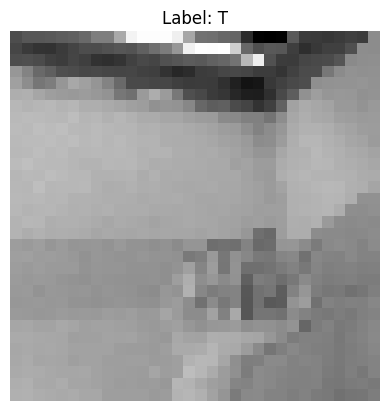

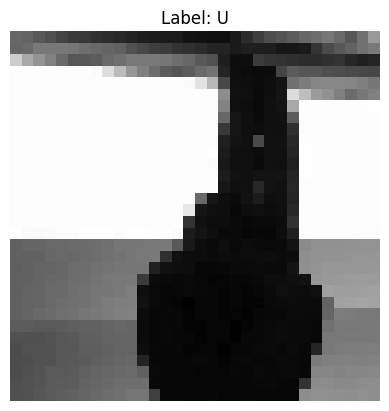

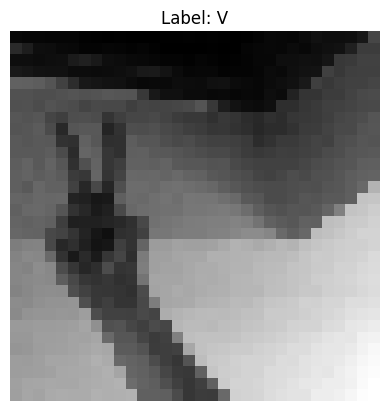

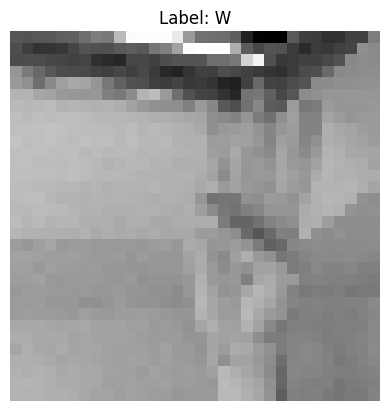

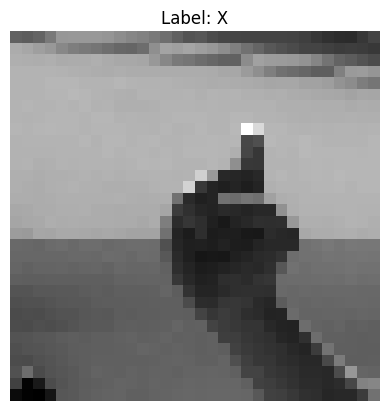

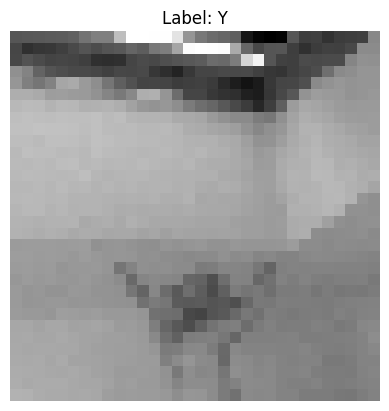

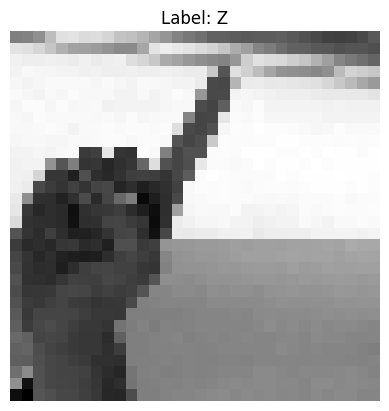

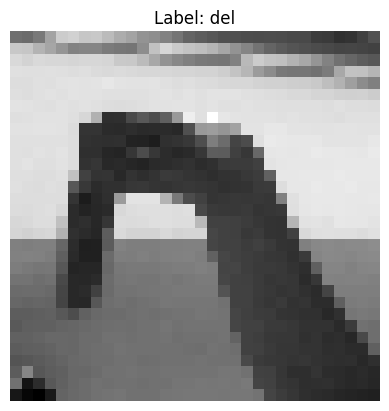

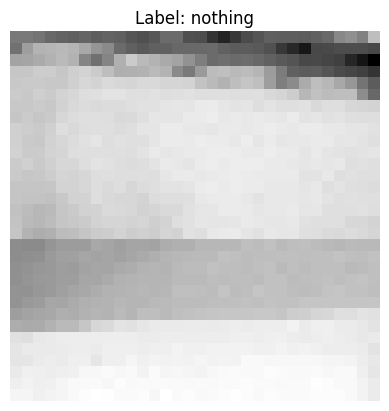

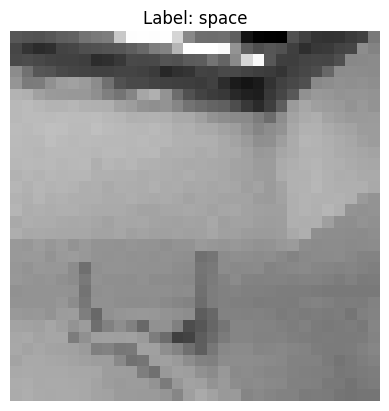

In [3]:
# Loading the saved NumPy arrays
load_directory = "/content/drive/MyDrive/Colab Notebooks/Sign2Text/"
X_train = np.load(os.path.join(load_directory, 'X_train.npy'))
y_train = np.load(os.path.join(load_directory, 'y_train.npy'))

# Finding unique labels in the training set
distinct_labels = np.unique(y_train)

# Defining the mapping from integer labels back to string labels
int_to_label = {i: label for label, i in label_to_int.items()}

# Visualizing one sample for each distinct label
for label in distinct_labels:
    # Finding the first occurrence of this label in the training set
    index = np.where(y_train == label)[0][0]

    image = X_train[index]
    label_name = int_to_label[label]

    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label_name}')
    plt.axis('off')
    plt.show()

Model Architecture

In [2]:
# Creating the model architecture
# Defining the model
model = Sequential()

# Convolutional and Pooling Layers with L2 regularization
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 1), kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Flattening the feature maps
model.add(Flatten())

# Fully Connected Layers with L2 regularization
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Defining callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1, factor=0.5, min_lr=1)

# Displaying the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 15, 15, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                        

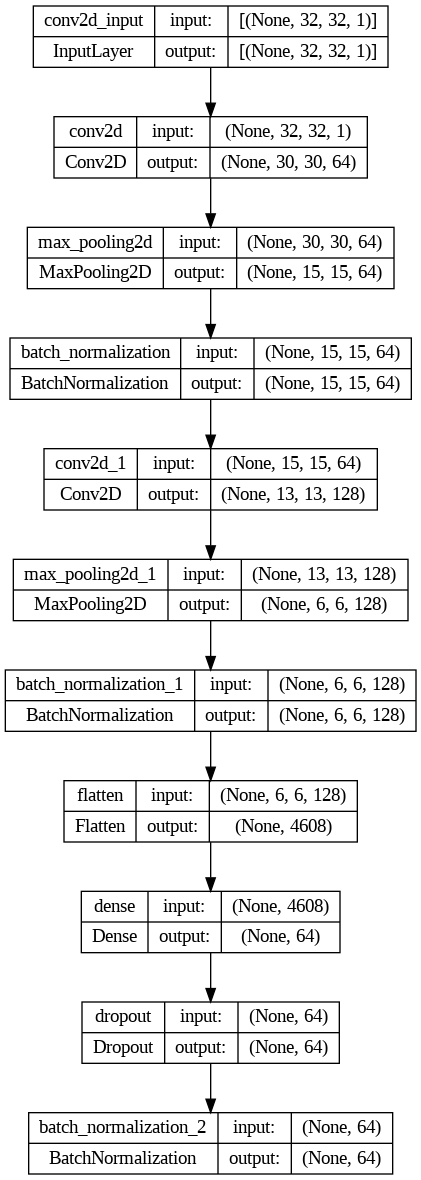

In [3]:
# Creating a box plot with jitter
# Generating the model architecture plot
plot_model(model, show_shapes = True, show_layer_names = True, to_file = "/content/drive/MyDrive/Colab Notebooks/Sign2Text/Sign2Text_architecture.png")

# Displaying the image
display(Image(filename = "/content/drive/MyDrive/Colab Notebooks/Sign2Text/Sign2Text_architecture.png"))

In [4]:
# Adding output layer
num_signs = 39
model.add(Dense(num_signs, activation="softmax", name="output_layer_signs", kernel_regularizer=l2(0.1)))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss={'output_layer_signs': 'sparse_categorical_crossentropy'}, metrics=['accuracy'])

Training the model and evaluating it

In [5]:
# Loading the preprocessed training data
X_train = np.load("/content/drive/MyDrive/Colab Notebooks/Sign2Text/X_train.npy")
y_train = np.load("/content/drive/MyDrive/Colab Notebooks/Sign2Text/y_train.npy")

# Converting NumPy arrays to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int64)

# Training the model
model.fit(X_train_tensor, y_train_tensor, epochs=21, verbose=1)

Epoch 1/21
2477/2477 [==============================] - 31s 6ms/step - loss: 2.6490 - accuracy: 0.6508
Epoch 2/21
2477/2477 [==============================] - 14s 6ms/step - loss: 1.5961 - accuracy: 0.8245
Epoch 3/21
2477/2477 [==============================] - 14s 6ms/step - loss: 1.3215 - accuracy: 0.8624
Epoch 4/21
2477/2477 [==============================] - 13s 5ms/step - loss: 1.1932 - accuracy: 0.8778
Epoch 5/21
2477/2477 [==============================] - 14s 6ms/step - loss: 1.1294 - accuracy: 0.8812
Epoch 6/21
2477/2477 [==============================] - 14s 6ms/step - loss: 1.0695 - accuracy: 0.8866
Epoch 7/21
2477/2477 [==============================] - 15s 6ms/step - loss: 1.0447 - accuracy: 0.8863
Epoch 8/21
2477/2477 [==============================] - 14s 6ms/step - loss: 1.0213 - accuracy: 0.8883
Epoch 9/21
2477/2477 [==============================] - 14s 6ms/step - loss: 0.9998 - accuracy: 0.8920
Epoch 10/21
2477/2477 [==============================] - 14s 6ms/step - l

In [6]:
# Loading the preprocessed testing data
X_test = np.load("/content/drive/MyDrive/Colab Notebooks/Sign2Text/X_test.npy")
y_test = np.load("/content/drive/MyDrive/Colab Notebooks/Sign2Text/y_test.npy")

# Convert NumPy arrays to TensorFlow tensors
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int64)

# Evaluating the model using the test dataset
evaluation = model.evaluate(X_test_tensor, y_test_tensor, verbose=1)

# Extracting the loss and accuracy from the evaluation result
test_loss = evaluation[0]
test_accuracy = evaluation[1]

# Printing the evaluation results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predicting the labels for the test dataset
predictions = model.predict(X_test_tensor)

# Converting the predictions to label indices
predicted_indices = np.argmax(predictions, axis=1)

# Calculating the accuracy
accuracy = np.mean(predicted_indices == y_test)
print("Predicted Accuracy: ", accuracy)

1062/1062 [==============================] - 4s 3ms/step - loss: 0.8213 - accuracy: 0.9312
Test Loss: 0.8213
Test Accuracy: 93.12%
1062/1062 [==============================] - 3s 3ms/step
Predicted Accuracy:  0.9312487118334658


Saving the model

In [7]:
model.save("/content/drive/MyDrive/Colab Notebooks/Sign2Text/Sign2Text.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
# Loading model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Sign2Text/Sign2Text.h5')

# Saving as ".keras" format
model.save("/content/drive/MyDrive/Colab Notebooks/Sign2Text/Sign2Text.keras")